In [22]:
import torch
import torch.nn as nn

from torch.utils.data import TensorDataset, Dataset, DataLoader, random_split

from torchvision.transforms import v2

import matplotlib.pyplot as plt
import pandas as pd

from tqdm import tqdm

In [23]:
df = pd.read_csv('../res/prepared_data.csv')

In [24]:
df.head()

,competition_id,season,round,home_club_id,away_club_id,home_club_goals,away_club_goals,home_club_position,away_club_position,home_club_manager_name,...,month,day,dayofweek,home_club_formation_code,away_club_formation_code,net_transfer_record_home_num,net_transfer_record_away_num,stadium_code,stadium_name_home_code,stadium_name_away_code
0,-1.270845,-1.315944,-1.281584,-0.374854,-0.374635,1.073348,1.456098,-0.249495,-0.080008,-1.294868,...,0.356065,-0.544828,0.859005,-0.786416,-0.811003,0.374295,-0.086558,-1.456036,-1.470120,-1.439102
1,-1.270845,-1.315944,-1.281584,-0.376031,-0.369285,-1.161622,-0.191235,0.755516,-0.480396,-1.292192,...,0.356065,-0.656934,0.293306,-0.629760,0.275239,0.105489,0.050652,-1.448966,-1.463678,-0.730257
2,-1.270845,-1.315944,-1.225685,-0.376855,-0.376775,0.328358,-0.191235,-1.656509,1.121156,-1.289517,...,0.356065,0.239909,0.859005,-0.786416,-0.655825,-0.776929,0.103620,-1.441897,-1.457235,-1.464878
3,-1.270845,-1.315944,-1.169787,-0.376031,-0.376657,-1.161622,0.632432,1.760526,0.320380,-1.292192,...,0.356065,1.024647,0.859005,-0.629760,-0.811003,0.105489,1.440217,-1.448966,-1.463678,2.607757
4,-1.270845,-1.315944,-1.113888,-0.376855,-0.374635,3.308319,0.632432,-1.656509,1.121156,-1.289517,...,0.619340,-0.208512,0.293306,-0.786416,1.827013,-0.776929,-0.086558,-1.441897,-1.457235,-1.439102


In [25]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

# Підготовка даних

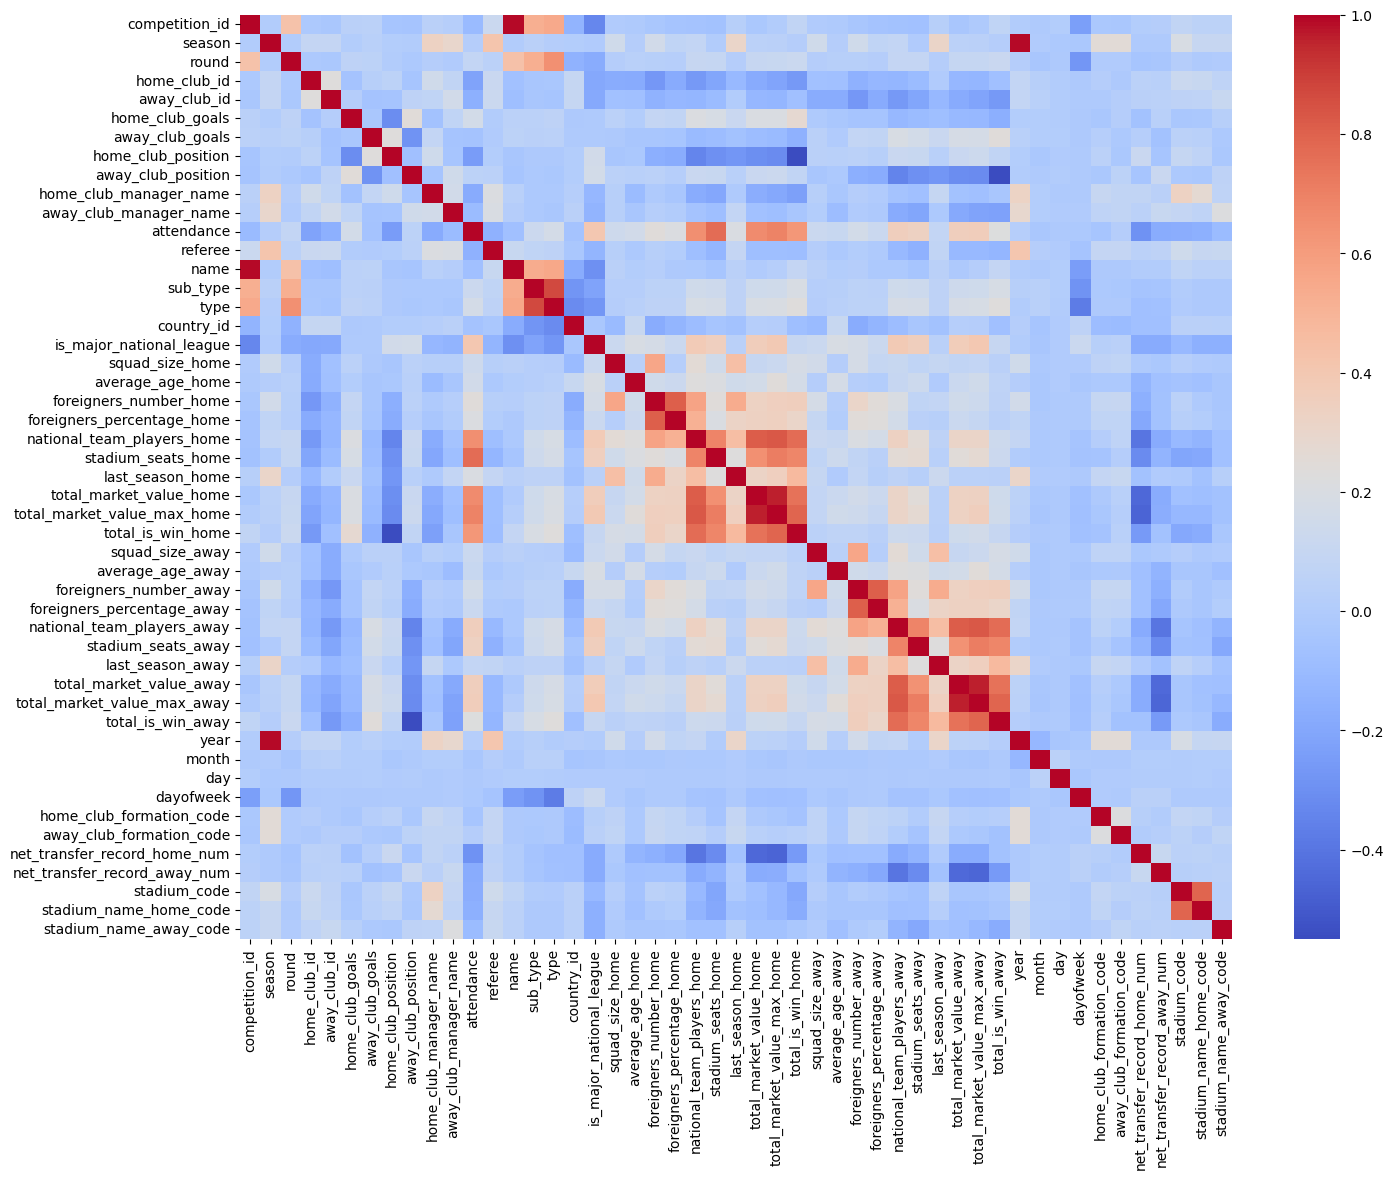

In [26]:
import seaborn as sns
corr_matrix = df.corr()
plt.figure(figsize=(16, 12))
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm')
plt.show()

In [27]:
df['is_major_national_league'] = df['is_major_national_league'].astype(float)

In [28]:
X = df.drop(['home_club_goals', 'away_club_goals'], axis=1)
y = df[['home_club_goals', 'away_club_goals']]

In [29]:
# Перетворити X, y у тензори
X_tensor = torch.tensor(X.values, dtype=torch.float32).to(device)
y_tensor = torch.tensor(y.values, dtype=torch.float32).to(device)

# Створити датасет
dataset = TensorDataset(X_tensor, y_tensor)

In [30]:
# Розділити
train_dataset, val_dataset, test_dataset = random_split(dataset, [0.7, 0.15, 0.15])

In [31]:
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Створення моделі

In [32]:
class MyModel(nn.Module):
    def __init__(self, input, output):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(input, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.5),

            nn.Linear(256, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(0.5),

            nn.Linear(64, 8),
            nn.BatchNorm1d(8),
            nn.ReLU(),
            nn.Dropout(0.5),

            nn.Linear(8, output)
        )

    def forward(self, x):
        x = self.model(x)

        return x

In [33]:
model = MyModel(len(X.columns), len(y.columns)).to(device)

In [34]:
data = torch.rand([64, len(X.columns)], dtype=torch.float32).to(device)

out = model(data)
out.shape

torch.Size([64, 2])

In [35]:
# Визначаємо функцію втрат і оптимізації градієнтного спуску
loss_model = nn.MSELoss()
opt = torch.optim.Adam(model.parameters(), lr=0.001)

lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    opt,
    mode='min',
    factor=0.1,
    patience=5
)

# Тренування моделі

In [36]:
import os

folder = '../res/models'

for filename in os.listdir(folder):
    if filename == '.gitkeep':
        continue
    file_path = os.path.join(folder, filename)
    if os.path.isfile(file_path):
        os.remove(file_path)

In [37]:
EPOCHS = 100
train_loss = []
train_acc = []
val_loss = []
val_acc = []
lr_list = []
threshold = 0.1
best_loss = None

# win, draw, defeat acc
train_wdd_acc = []
val_wdd_acc = []

In [38]:
import joblib

scaler = joblib.load('../res/scaler_y.joblib')

In [39]:
def get_wdd_class(goals):
    # goals: tensor [..., 2] (home, away)
    diff = goals[:, 0] - goals[:, 1]
    res = torch.zeros_like(diff)
    res[diff > 0] = 1
    res[diff < 0] = -1
    return res

In [ ]:
count = 0

# Цикл навчання
for epoch in range(EPOCHS):
    model.train()
    running_train_loss = [] # Для збереження втрат на кожному батчі
    correct_train = 0
    total_train = 0

    correct_wdd = 0
    total_wdd = 0

    train_loop = tqdm(train_loader, leave=False) # при (leave=False) прогрес буде видалятися з консолі, щоб не засмічувати її
    for x, targets in train_loop:
        # Пряме поширення, розрахунок помилки
        pred = model(x) # Розраховуємо результати передбачень
        loss = loss_model(pred, targets) # Розраховуємо на скільки модель помилилась

        # Зворотне поширення похибки
        opt.zero_grad() # Обнуляємо раніше розраховані градієнти
        loss.backward() # Розраховуємо вплив нейронів на отриману похибку

        # Оптимізація
        opt.step() # Виконуємо корегування нейронів

        running_train_loss.append(loss.item())
        mean_train_loss = sum(running_train_loss) / len(running_train_loss)

        # --- Accuracy ---
        pred_unscale = torch.tensor(scaler.inverse_transform(pred.cpu().detach().numpy()), dtype=torch.float32).to(device)
        targets_unscale = torch.tensor(scaler.inverse_transform(targets.cpu().detach().numpy()), dtype=torch.float32).to(device)

        diff = torch.abs(pred_unscale - targets_unscale)
        correct_train += ((diff <= 0.5).all(dim=1)).sum().item()  # обидва голи в межах 0.5
        total_train += targets.size(0)

        # --- Win, draw, defeat accuracy ---
        pred_wdd = get_wdd_class(pred_unscale)
        true_wdd = get_wdd_class(targets_unscale)
        correct_wdd += (pred_wdd == true_wdd).sum().item()
        total_wdd += targets.size(0)

        train_loop.set_description(f'Epoch [{epoch + 1} / {EPOCHS}], train_loss = {mean_train_loss:.4f}, train_val = {(correct_train / total_train):.4f}')

    # Збереження значення функції втрат і метрик
    train_loss.append(mean_train_loss)
    train_acc.append(correct_train / total_train)
    train_wdd_acc.append(correct_wdd / total_wdd)

    # Перевірка моделі
    model.eval()
    running_val_loss = []
    correct_val = 0
    total_val = 0
    correct_wdd_val = 0
    total_wdd_val = 0
    with torch.no_grad(): # Забороняємо розрахунок градієнтів для цього блоку
        for x, targets in val_loader:
            # Пряме поширення, розрахунок помилки
            pred = model(x)
            loss = loss_model(pred, targets)

            running_val_loss.append(loss.item())

            # --- Accuracy ---
            pred_unscale = torch.tensor(scaler.inverse_transform(pred.cpu().detach().numpy()), dtype=torch.float32).to(device)
            targets_unscale = torch.tensor(scaler.inverse_transform(targets.cpu().detach().numpy()), dtype=torch.float32).to(device)

            diff = torch.abs(pred_unscale - targets_unscale)
            correct = ((diff <= 0.5).all(dim=1)).sum().item()
            correct_val += correct
            total_val += targets.size(0)

            # --- Win, draw, defeat accuracy ---
            pred_wdd = get_wdd_class(pred_unscale)
            true_wdd = get_wdd_class(targets_unscale)
            correct_wdd_val += (pred_wdd == true_wdd).sum().item()
            total_wdd_val += targets.size(0)


    # Збереження значення функції втрат і метрик
    mean_val_loss = sum(running_val_loss) / len(running_val_loss)
    val_loss.append(mean_val_loss)
    val_acc.append(correct_val / total_val)
    val_wdd_acc.append(correct_wdd_val / total_wdd_val)

    # Зміна швидкості навчання
    lr_scheduler.step(mean_val_loss)
    lr = lr_scheduler.get_last_lr()[0]
    lr_list.append(lr)

    # Виведення результатів епохи
    print(f'Epoch [{epoch + 1} / {EPOCHS}], train_loss={mean_train_loss:.4f}, train_acc={train_acc[-1]:.4f}, train_wdd_acc={train_wdd_acc[-1]:.4f}, val_loss={mean_val_loss:.4f}, val_acc={val_acc[-1]:.4f}, val_wdd_acc={val_wdd_acc[-1]:.4f}, lr={lr:.4f}')

    # Зупинка навчання
    if best_loss is None:
        best_loss = mean_val_loss

    if mean_val_loss < best_loss - best_loss * threshold: # можна - mean_val_loss < best_loss, але так правильніше
        best_loss = mean_val_loss
        count = 0

        checkpoint = {
            'state_model': model.state_dict(),
            'state_opt': opt.state_dict(),
            'state_lr_scheduler': lr_scheduler.state_dict(),
            'loss': {
                'train_loss': train_loss,
                'val_loss': val_loss,
                'best_loss': best_loss
            },
            'metric': {
                'train_acc': train_acc,
                'val_acc': val_acc,
                'train_wdd_acc': train_wdd_acc,
                'val_wdd_acc': val_wdd_acc
            },
            'lr': lr_list,
            'epoch': {
                'EPOCHS': EPOCHS,
                'epoch': epoch
            }
        }

        torch.save(checkpoint, f'../res/models/model_state_dict_epoch_{epoch + 1}.pt')

    if count >= 10 and epoch >= 50:
        print(f'\033[31mНавчання зупинено на {epoch + 1} епосі.\033[0m')
        break
    
    count += 1

Epoch [1 / 100], train_loss=0.9763, train_acc=0.1030, train_wdd_acc=0.5725, val_loss=0.8964, val_acc=0.1213, val_wdd_acc=0.6193, lr=0.0010


Epoch [2 / 100], train_loss=0.8974, train_acc=0.1161, train_wdd_acc=0.6069, val_loss=0.8840, val_acc=0.1207, val_wdd_acc=0.6470, lr=0.0010


Epoch [3 / 100], train_loss=0.8877, train_acc=0.1192, train_wdd_acc=0.6192, val_loss=0.8812, val_acc=0.1230, val_wdd_acc=0.6439, lr=0.0010


Epoch [4 / 100], train_loss=0.8847, train_acc=0.1185, train_wdd_acc=0.6234, val_loss=0.8835, val_acc=0.1240, val_wdd_acc=0.6456, lr=0.0010


Epoch [5 / 100], train_loss=0.8813, train_acc=0.1181, train_wdd_acc=0.6251, val_loss=0.8762, val_acc=0.1216, val_wdd_acc=0.6489, lr=0.0010


Epoch [6 / 100], train_loss=0.8813, train_acc=0.1223, train_wdd_acc=0.6241, val_loss=0.8736, val_acc=0.1246, val_wdd_acc=0.6523, lr=0.0010


Epoch [7 / 100], train_loss=0.8816, train_acc=0.1206, train_wdd_acc=0.6294, val_loss=0.8803, val_acc=0.1245, val_wdd_acc=0.6530, lr=0.0010


Epoch [8 / 100], train_loss=0.8793, train_acc=0.1219, train_wdd_acc=0.6257, val_loss=0.8772, val_acc=0.1266, val_wdd_acc=0.6521, lr=0.0010


Epoch [9 / 100], train_loss=0.8805, train_acc=0.1211, train_wdd_acc=0.6251, val_loss=0.8751, val_acc=0.1250, val_wdd_acc=0.6498, lr=0.0010


Epoch [10 / 100], train_loss=0.8785, train_acc=0.1208, train_wdd_acc=0.6281, val_loss=0.8751, val_acc=0.1276, val_wdd_acc=0.6512, lr=0.0010


Epoch [11 / 100], train_loss=0.8786, train_acc=0.1204, train_wdd_acc=0.6263, val_loss=0.8763, val_acc=0.1274, val_wdd_acc=0.6481, lr=0.0010


Epoch [12 / 100], train_loss=0.8763, train_acc=0.1214, train_wdd_acc=0.6261, val_loss=0.8763, val_acc=0.1263, val_wdd_acc=0.6515, lr=0.0001


Epoch [13 / 100], train_loss=0.8752, train_acc=0.1216, train_wdd_acc=0.6300, val_loss=0.8742, val_acc=0.1289, val_wdd_acc=0.6494, lr=0.0001


Epoch [14 / 100], train_loss=0.8779, train_acc=0.1219, train_wdd_acc=0.6285, val_loss=0.8729, val_acc=0.1274, val_wdd_acc=0.6556, lr=0.0001


Epoch [15 / 100], train_loss=0.8756, train_acc=0.1209, train_wdd_acc=0.6312, val_loss=0.8734, val_acc=0.1277, val_wdd_acc=0.6470, lr=0.0001


Epoch [16 / 100], train_loss=0.8707, train_acc=0.1224, train_wdd_acc=0.6272, val_loss=0.8719, val_acc=0.1278, val_wdd_acc=0.6465, lr=0.0001


Epoch [17 / 100], train_loss=0.8765, train_acc=0.1213, train_wdd_acc=0.6267, val_loss=0.8716, val_acc=0.1270, val_wdd_acc=0.6519, lr=0.0001


Epoch [18 / 100], train_loss=0.8719, train_acc=0.1221, train_wdd_acc=0.6277, val_loss=0.8695, val_acc=0.1268, val_wdd_acc=0.6503, lr=0.0001


Epoch [19 / 100], train_loss=0.8721, train_acc=0.1205, train_wdd_acc=0.6302, val_loss=0.8720, val_acc=0.1269, val_wdd_acc=0.6455, lr=0.0001


Epoch [20 / 100], train_loss=0.8700, train_acc=0.1233, train_wdd_acc=0.6310, val_loss=0.8710, val_acc=0.1282, val_wdd_acc=0.6507, lr=0.0001


Epoch [21 / 100], train_loss=0.8710, train_acc=0.1238, train_wdd_acc=0.6265, val_loss=0.8712, val_acc=0.1272, val_wdd_acc=0.6486, lr=0.0001


Epoch [22 / 100], train_loss=0.8703, train_acc=0.1222, train_wdd_acc=0.6296, val_loss=0.8695, val_acc=0.1274, val_wdd_acc=0.6505, lr=0.0001


Epoch [23 / 100], train_loss=0.8722, train_acc=0.1208, train_wdd_acc=0.6286, val_loss=0.8734, val_acc=0.1278, val_wdd_acc=0.6433, lr=0.0001


Epoch [24 / 100], train_loss=0.8750, train_acc=0.1218, train_wdd_acc=0.6258, val_loss=0.8700, val_acc=0.1272, val_wdd_acc=0.6495, lr=0.0000


Epoch [25 / 100], train_loss=0.8719, train_acc=0.1228, train_wdd_acc=0.6295, val_loss=0.8709, val_acc=0.1276, val_wdd_acc=0.6493, lr=0.0000


Epoch [26 / 100], train_loss=0.8740, train_acc=0.1213, train_wdd_acc=0.6278, val_loss=0.8706, val_acc=0.1282, val_wdd_acc=0.6526, lr=0.0000


Epoch [27 / 100], train_loss=0.8707, train_acc=0.1233, train_wdd_acc=0.6278, val_loss=0.8684, val_acc=0.1278, val_wdd_acc=0.6549, lr=0.0000


Epoch [28 / 100], train_loss=0.8714, train_acc=0.1205, train_wdd_acc=0.6305, val_loss=0.8724, val_acc=0.1269, val_wdd_acc=0.6472, lr=0.0000


Epoch [29 / 100], train_loss=0.8695, train_acc=0.1223, train_wdd_acc=0.6319, val_loss=0.8729, val_acc=0.1277, val_wdd_acc=0.6479, lr=0.0000


Epoch [30 / 100], train_loss=0.8738, train_acc=0.1228, train_wdd_acc=0.6291, val_loss=0.8735, val_acc=0.1286, val_wdd_acc=0.6482, lr=0.0000


Epoch [31 / 100], train_loss=0.8715, train_acc=0.1201, train_wdd_acc=0.6285, val_loss=0.8692, val_acc=0.1272, val_wdd_acc=0.6488, lr=0.0000


Epoch [32 / 100], train_loss=0.8714, train_acc=0.1215, train_wdd_acc=0.6308, val_loss=0.8698, val_acc=0.1276, val_wdd_acc=0.6486, lr=0.0000


Epoch [33 / 100], train_loss=0.8716, train_acc=0.1223, train_wdd_acc=0.6272, val_loss=0.8701, val_acc=0.1274, val_wdd_acc=0.6461, lr=0.0000


Epoch [34 / 100], train_loss=0.8715, train_acc=0.1227, train_wdd_acc=0.6288, val_loss=0.8704, val_acc=0.1263, val_wdd_acc=0.6481, lr=0.0000


Epoch [35 / 100], train_loss=0.8725, train_acc=0.1204, train_wdd_acc=0.6272, val_loss=0.8689, val_acc=0.1263, val_wdd_acc=0.6445, lr=0.0000


Epoch [36 / 100], train_loss=0.8720, train_acc=0.1195, train_wdd_acc=0.6279, val_loss=0.8702, val_acc=0.1282, val_wdd_acc=0.6502, lr=0.0000


Epoch [37 / 100], train_loss=0.8726, train_acc=0.1222, train_wdd_acc=0.6293, val_loss=0.8685, val_acc=0.1278, val_wdd_acc=0.6493, lr=0.0000


Epoch [38 / 100], train_loss=0.8732, train_acc=0.1225, train_wdd_acc=0.6231, val_loss=0.8722, val_acc=0.1273, val_wdd_acc=0.6477, lr=0.0000


Epoch [39 / 100], train_loss=0.8712, train_acc=0.1213, train_wdd_acc=0.6276, val_loss=0.8703, val_acc=0.1277, val_wdd_acc=0.6449, lr=0.0000


Epoch [40 / 100], train_loss=0.8726, train_acc=0.1226, train_wdd_acc=0.6300, val_loss=0.8705, val_acc=0.1271, val_wdd_acc=0.6455, lr=0.0000


Epoch [41 / 100], train_loss=0.8708, train_acc=0.1218, train_wdd_acc=0.6302, val_loss=0.8714, val_acc=0.1272, val_wdd_acc=0.6468, lr=0.0000


Epoch [42 / 100], train_loss=0.8726, train_acc=0.1231, train_wdd_acc=0.6289, val_loss=0.8720, val_acc=0.1280, val_wdd_acc=0.6493, lr=0.0000


Epoch [43 / 100], train_loss=0.8701, train_acc=0.1231, train_wdd_acc=0.6299, val_loss=0.8709, val_acc=0.1285, val_wdd_acc=0.6523, lr=0.0000


Epoch [44 / 100], train_loss=0.8708, train_acc=0.1211, train_wdd_acc=0.6279, val_loss=0.8690, val_acc=0.1278, val_wdd_acc=0.6498, lr=0.0000


Epoch [45 / 100], train_loss=0.8737, train_acc=0.1212, train_wdd_acc=0.6274, val_loss=0.8723, val_acc=0.1283, val_wdd_acc=0.6498, lr=0.0000


Epoch [46 / 100], train_loss=0.8704, train_acc=0.1227, train_wdd_acc=0.6305, val_loss=0.8706, val_acc=0.1277, val_wdd_acc=0.6493, lr=0.0000


Epoch [47 / 100], train_loss=0.8713, train_acc=0.1241, train_wdd_acc=0.6304, val_loss=0.8736, val_acc=0.1271, val_wdd_acc=0.6404, lr=0.0000


Epoch [48 / 100], train_loss=0.8712, train_acc=0.1236, train_wdd_acc=0.6301, val_loss=0.8720, val_acc=0.1254, val_wdd_acc=0.6391, lr=0.0000


Epoch [49 / 100], train_loss=0.8705, train_acc=0.1223, train_wdd_acc=0.6303, val_loss=0.8703, val_acc=0.1279, val_wdd_acc=0.6520, lr=0.0000


Epoch [50 / 100], train_loss=0.8706, train_acc=0.1235, train_wdd_acc=0.6298, val_loss=0.8701, val_acc=0.1271, val_wdd_acc=0.6470, lr=0.0000


Epoch [51 / 100], train_loss=0.8699, train_acc=0.1234, train_wdd_acc=0.6291, val_loss=0.8716, val_acc=0.1279, val_wdd_acc=0.6506, lr=0.0000
Навчання зупинено на 51 епосі.


In [41]:
checkpoint = {
    'state_model': model.state_dict(),
    'state_opt': opt.state_dict(),
    'state_lr_scheduler': lr_scheduler.state_dict(),
    'loss': {
        'train_loss': train_loss,
        'val_loss': val_loss,
        'best_loss': best_loss
    },
    'metric': {
        'train_acc': train_acc,
        'val_acc': val_acc,
        'train_wdd_acc': train_wdd_acc,
        'val_wdd_acc': val_wdd_acc
    },
    'lr': lr_list,
    'epoch': {
        'EPOCHS': EPOCHS,
        'epoch': epoch
    }
}

torch.save(checkpoint, f'../res/models/model_state_dict_epoch_{epoch + 1}.pt')

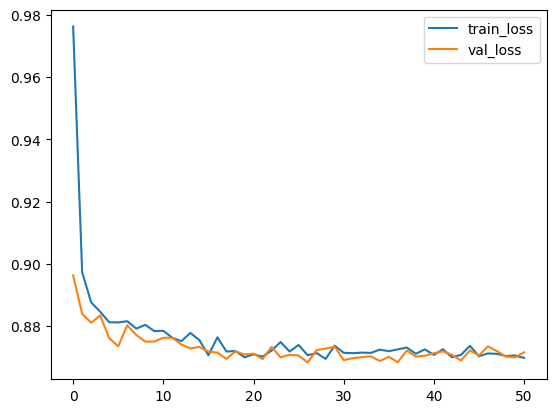

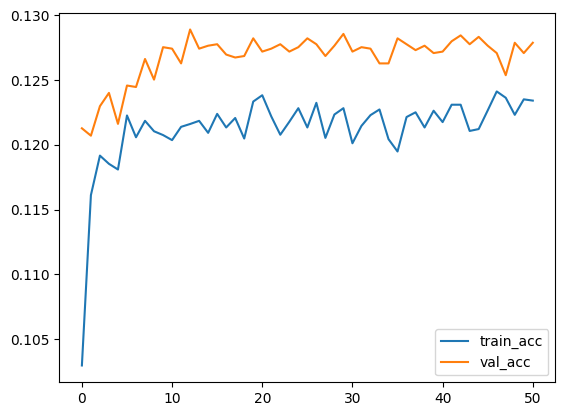

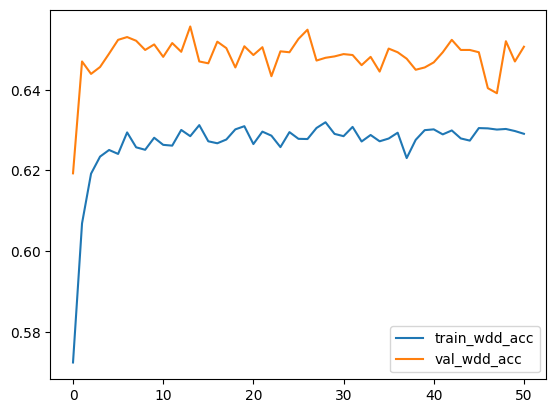

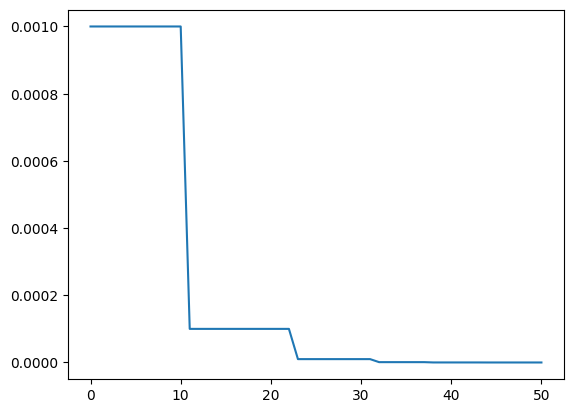

In [42]:
plt.plot(train_loss)
plt.plot(val_loss)
plt.legend(['train_loss', 'val_loss'])
plt.show()

plt.plot(train_acc)
plt.plot(val_acc)
plt.legend(['train_acc', 'val_acc'])
plt.show()

plt.plot(train_wdd_acc)
plt.plot(val_wdd_acc)
plt.legend(['train_wdd_acc', 'val_wdd_acc'])
plt.show()

plt.plot(lr_list)
plt.show()